In [39]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

import sys
import numpy as np
from surprise import AlgoBase, Dataset
from surprise.model_selection.validation import cross_validate
import pandas as pd

from scipy.sparse import csr_matrix

import pyspark
from pyspark.sql.types import *
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from sklearn.metrics.pairwise import cosine_similarity


# Build our Spark Session and Context
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext
spark, sc


from pyspark.sql.functions import lit
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.sql.functions import countDistinct, col

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

schema = StructType([
    StructField("user", IntegerType(), True),
    StructField("movie", IntegerType(), True),
    StructField("rating", FloatType(), True),
    StructField("timestamp", IntegerType(), True)])

In [26]:
df_ratings = spark.read.csv('../data/ml-latest-small/ratings.csv', sep =',', header=True, schema=schema)
df_ratings = df_ratings.drop('timestamp')

In [52]:
# df = pd.read_csv('../data/ml-latest-small/ratings.csv')
# df = df.drop('timestamp', axis = 1)
# df = df.pivot_table(values='rating', index='userId', columns='movieId')
# df = spark.createDataFrame(df)
df_ratings.show()

+----+-----+------+
|user|movie|rating|
+----+-----+------+
|   1|    1|   4.0|
|   1|    3|   4.0|
|   1|    6|   4.0|
|   1|   47|   5.0|
|   1|   50|   5.0|
|   1|   70|   3.0|
|   1|  101|   5.0|
|   1|  110|   4.0|
|   1|  151|   5.0|
|   1|  157|   5.0|
|   1|  163|   5.0|
|   1|  216|   5.0|
|   1|  223|   3.0|
|   1|  231|   5.0|
|   1|  235|   4.0|
|   1|  260|   5.0|
|   1|  296|   3.0|
|   1|  316|   3.0|
|   1|  333|   5.0|
|   1|  349|   4.0|
+----+-----+------+
only showing top 20 rows



In [62]:
df = df_ratings.toPandas()
df['rating'].unique()

array([4. , 5. , 3. , 2. , 1. , 4.5, 3.5, 2.5, 0.5, 1.5], dtype=float32)

In [30]:
print('Number of unique users: {}'.format(df_ratings.select('user').distinct().count()))
print('Number of unique movies: {}'.format(df_ratings.select('movie').distinct().count()))
print('Number of rating: {}'.format(df_ratings.count()))

Number of unique users: 610
Number of unique movies: 9724
Number of rating: 100836


In [31]:
train, test = df_ratings.randomSplit([0.8, 0.2], seed=100)

Max Ratings: 2201
Min Ratings: 14


<AxesSubplot:>

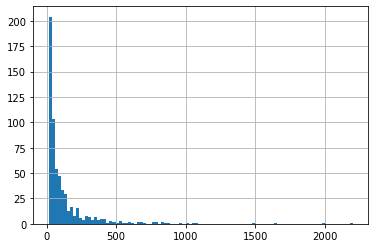

In [49]:
user_count = train.groupBy('user').count().toPandas()

print('Max Ratings: {}'.format(user_count['count'].max()))
print('Min Ratings: {}'.format(user_count['count'].min()))
user_count['count'].hist(bins = 100)

Max Ratings: 264
Min Ratings: 1


<AxesSubplot:>

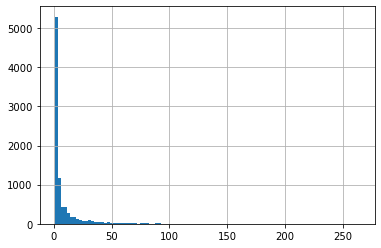

In [50]:
movie_count = train.groupBy('movie').count().toPandas()

print('Max Ratings: {}'.format(movie_count['count'].max()))
print('Min Ratings: {}'.format(movie_count['count'].min()))
movie_count['count'].hist(bins = 100)

Max Ratings: 65
Min Ratings: 1


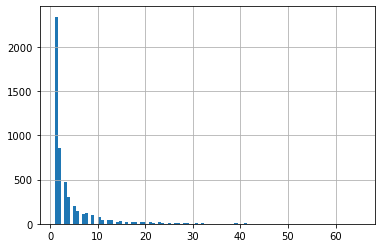

In [86]:
movie_count = test.groupBy('movie').count().toPandas()

print('Max Ratings: {}'.format(movie_count['count'].max()))
print('Min Ratings: {}'.format(movie_count['count'].min()))
movie_count['count'].hist(bins = 100)
train = train.withColumn("imp_rating", lit(1))

In [99]:
als_model = ALS(userCol='user',
                itemCol='movie',
                ratingCol='rating',
                nonnegative=True,
                regParam=0.1,
                rank=10,
               )

als = als_model.fit(train)

In [95]:
recommender_imp.recommendForUserSubset(one_row_spark_df, 10).collect()

NameError: name 'one_row_spark_df' is not defined

In [105]:
train_df = train.toPandas()
predictions = als.transform(test)
predictions_df = predictions.toPandas().fillna(train_df['rating'].mean())
predictions_df

,user,movie,rating,prediction
0,91,471,1.0,2.866915
1,603,471,4.0,3.002979
2,474,471,3.0,3.484408
3,500,471,1.0,3.184305
4,387,471,3.0,3.208374
...,...,...,...,...
20114,562,84374,3.5,3.297566
20115,21,107449,1.5,3.501790
20116,47,145839,3.5,1.539149
20117,210,147378,4.5,3.305344


In [106]:
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['prediction'])**2

In [103]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
predictions_df.show()

+----+-----+------+------------------+
|user|movie|rating|        prediction|
+----+-----+------+------------------+
|  91|  471|   1.0| 2.866914749145508|
| 603|  471|   4.0| 3.002978563308716|
| 474|  471|   3.0| 3.484407663345337|
| 500|  471|   1.0|  3.18430495262146|
| 387|  471|   3.0|   3.2083740234375|
| 469|  471|   5.0|3.8029422760009766|
| 426|  471|   5.0|3.3574657440185547|
| 357|  471|   3.5|3.7095420360565186|
| 609|  833|   3.0| 1.802220344543457|
| 159| 1088|   4.0| 2.475374937057495|
| 606| 1088|   3.0|3.1313986778259277|
| 177| 1088|   3.5|3.3739612102508545|
| 479| 1088|   4.0| 2.726405620574951|
|  64| 1088|   4.0|3.0621793270111084|
| 554| 1088|   5.0| 4.083161354064941|
| 563| 1088|   4.0|3.4982614517211914|
| 594| 1088|   4.5| 4.326696395874023|
| 104| 1088|   3.0|3.4089577198028564|
| 599| 1342|   2.5|2.0783307552337646|
| 312| 1342|   4.0|2.4514541625976562|
| 600| 1342|   2.5|1.4002046585083008|
|  34| 1580|   2.5| 3.304922580718994|
|  28| 1580|   3.0| 2.984

In [102]:
evaluator.evaluate(predictions_df)

0.8872708254636175